In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [3]:
# Load dataset
df = pd.read_excel("IT_Service_Desk_Data_100_Tickets.xlsx")

# Preview
df.head()


,TicketID,CreatedDate,ResolvedDate,Priority,Category,Technician,Status,SLA_Hours
0,3001,2025-01-30,2025-01-31,Medium,Network,Priya,Resolved,48
1,3002,2025-01-03,2025-01-06,Medium,Software,Sara,Resolved,48
2,3003,2025-01-17,2025-01-19,Medium,Software,David,Resolved,48
3,3004,2025-01-26,2025-01-30,High,Software,Sara,Resolved,24
4,3005,2025-01-03,2025-01-03,High,Access,Priya,Resolved,24


In [4]:
# Convert dates
df["CreatedDate"] = pd.to_datetime(df["CreatedDate"])
df["ResolvedDate"] = pd.to_datetime(df["ResolvedDate"])

# Calculate Resolution Days
df["ResolutionDays"] = (df["ResolvedDate"] - df["CreatedDate"]).dt.days

# SLA Met logic (SLA_Hours is in hours → convert to days)
df["SLA_Met"] = np.where(
    df["ResolutionDays"] <= (df["SLA_Hours"] / 24),
    "Yes",
    "No"
)

df.head()


,TicketID,CreatedDate,ResolvedDate,Priority,Category,Technician,Status,SLA_Hours,ResolutionDays,SLA_Met
0,3001,2025-01-30,2025-01-31,Medium,Network,Priya,Resolved,48,1,Yes
1,3002,2025-01-03,2025-01-06,Medium,Software,Sara,Resolved,48,3,No
2,3003,2025-01-17,2025-01-19,Medium,Software,David,Resolved,48,2,Yes
3,3004,2025-01-26,2025-01-30,High,Software,Sara,Resolved,24,4,No
4,3005,2025-01-03,2025-01-03,High,Access,Priya,Resolved,24,0,Yes


In [5]:
total_tickets = df["TicketID"].nunique()
avg_resolution_days = round(df["ResolutionDays"].mean(), 2)
sla_percentage = round((df["SLA_Met"].eq("Yes").mean()) * 100, 2)

print(f"Total Tickets: {total_tickets}")
print(f"Average Resolution Days: {avg_resolution_days}")
print(f"SLA Compliance %: {sla_percentage}")


Total Tickets: 100
Average Resolution Days: 1.92
SLA Compliance %: 68.0


In [6]:
df["SLA_Breach_Days"] = np.where(
    df["ResolutionDays"] > (df["SLA_Hours"] / 24),
    df["ResolutionDays"] - (df["SLA_Hours"] / 24),
    0
)


In [7]:
df["Aging_Bucket"] = pd.cut(
    df["ResolutionDays"],
    bins=[-1, 1, 3, 5, 10, np.inf],
    labels=["0-1 Day", "2-3 Days", "4-5 Days", "6-10 Days", "10+ Days"]
)

In [11]:
# Daily Ticket Intensity (TIME-BASED FEATURE)
daily_load = (
    df.groupby(df["CreatedDate"].dt.date)["TicketID"]
    .count()
    .rolling(7)
    .mean()
)

daily_load


CreatedDate
2025-01-01         NaN
2025-01-02         NaN
2025-01-03         NaN
2025-01-04         NaN
2025-01-05         NaN
2025-01-06         NaN
2025-01-07    4.142857
2025-01-08    4.000000
2025-01-10    4.714286
2025-01-11    4.000000
2025-01-12    4.000000
2025-01-13    3.714286
2025-01-14    3.571429
2025-01-15    3.285714
2025-01-16    4.142857
2025-01-17    3.714286
2025-01-18    3.571429
2025-01-19    3.714286
2025-01-20    3.714286
2025-01-21    3.714286
2025-01-23    3.714286
2025-01-24    2.857143
2025-01-25    2.714286
2025-01-26    2.714286
2025-01-27    3.000000
2025-01-28    3.000000
2025-01-29    2.857143
2025-01-30    3.142857
Name: TicketID, dtype: float64

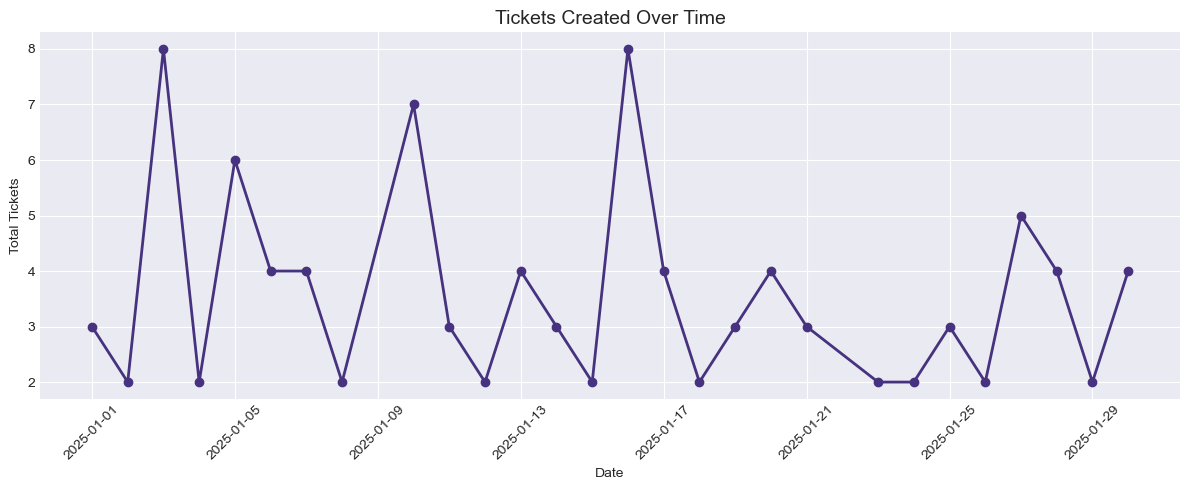

In [12]:
trend = df.groupby(df["CreatedDate"].dt.date)["TicketID"].count()

plt.figure(figsize=(12,5))
plt.plot(trend, marker="o", linewidth=2)
plt.title("Tickets Created Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Tickets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


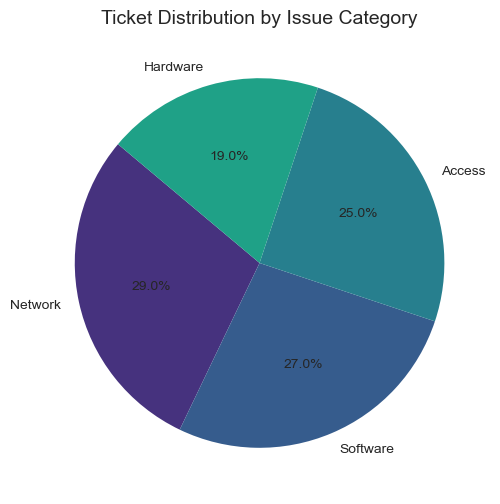

In [14]:
category_dist = df["Category"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    category_dist,
    labels=category_dist.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Ticket Distribution by Issue Category", fontsize=14)
plt.show()


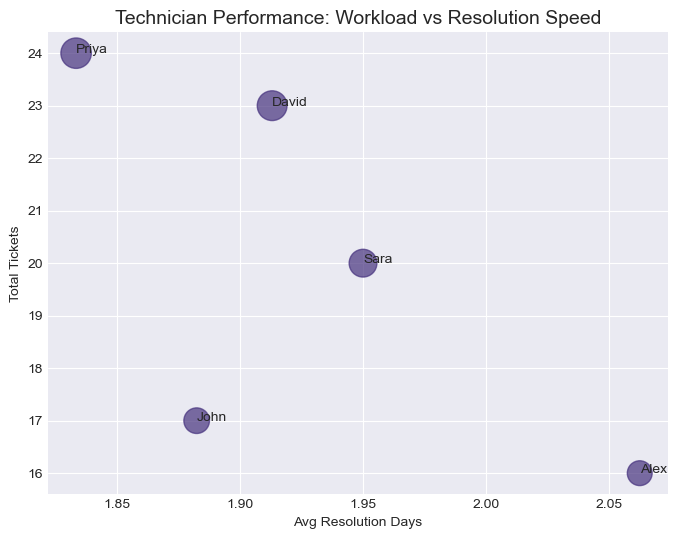

In [15]:
tech_perf = df.groupby("Technician").agg(
    TotalTickets=("TicketID", "count"),
    AvgResolutionDays=("ResolutionDays", "mean")
)

plt.figure(figsize=(8,6))
plt.scatter(
    tech_perf["AvgResolutionDays"],
    tech_perf["TotalTickets"],
    s=tech_perf["TotalTickets"]*20,
    alpha=0.7
)

for tech in tech_perf.index:
    plt.text(
        tech_perf.loc[tech, "AvgResolutionDays"],
        tech_perf.loc[tech, "TotalTickets"],
        tech
    )

plt.title("Technician Performance: Workload vs Resolution Speed", fontsize=14)
plt.xlabel("Avg Resolution Days")
plt.ylabel("Total Tickets")
plt.show()


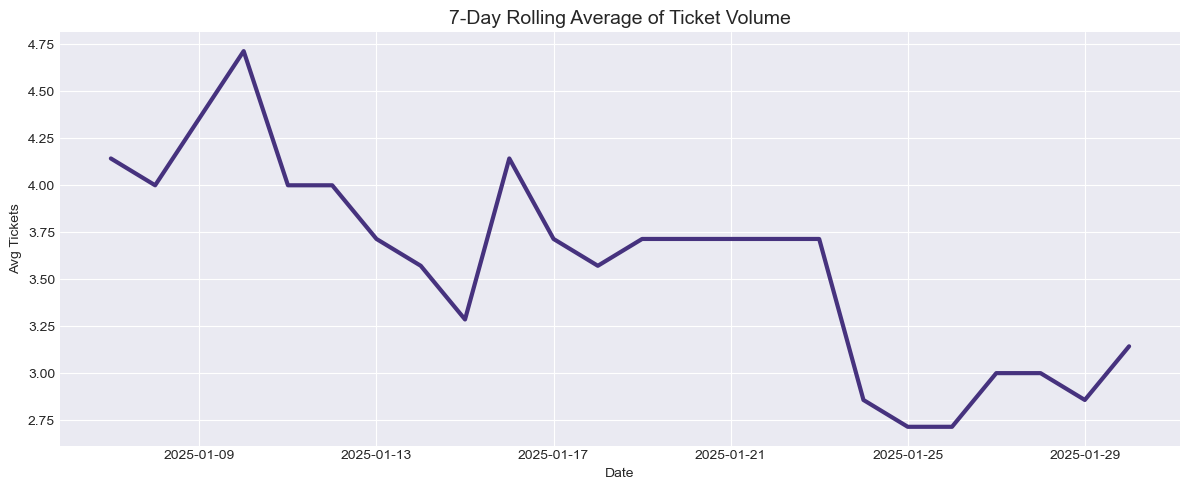

In [17]:
rolling_trend = (
    df.groupby(df["CreatedDate"].dt.date)["TicketID"]
    .count()
    .rolling(7)
    .mean()
)

plt.figure(figsize=(12,5))
plt.plot(rolling_trend, linewidth=3)
plt.title("7-Day Rolling Average of Ticket Volume", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Avg Tickets")
plt.tight_layout()
plt.show()


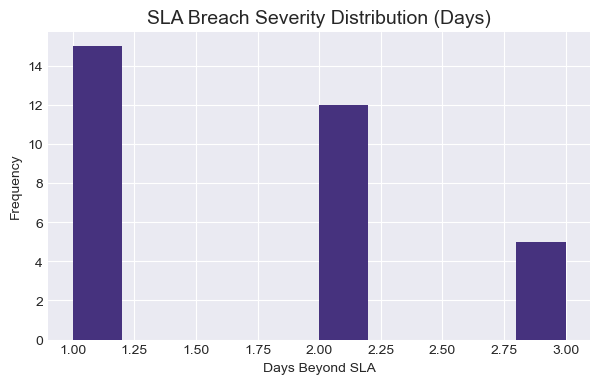

In [18]:
plt.figure(figsize=(7,4))
df[df["SLA_Breach_Days"] > 0]["SLA_Breach_Days"].plot(kind="hist", bins=10)
plt.title("SLA Breach Severity Distribution (Days)", fontsize=14)
plt.xlabel("Days Beyond SLA")
plt.show()


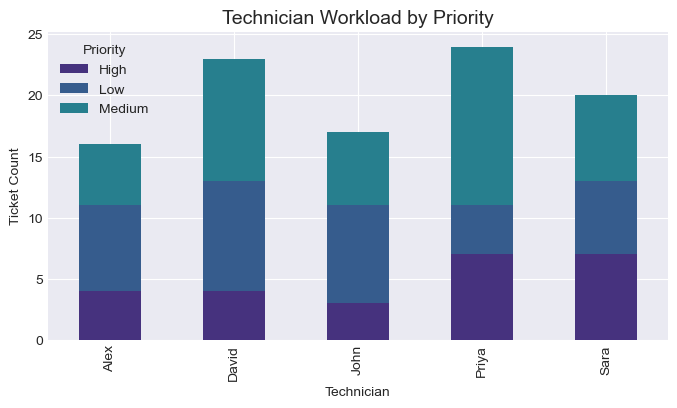

In [19]:
priority_stack = pd.crosstab(df["Technician"], df["Priority"])

priority_stack.plot(
    kind="bar",
    stacked=True,
    figsize=(8,4)
)
plt.title("Technician Workload by Priority", fontsize=14)
plt.ylabel("Ticket Count")
plt.show()


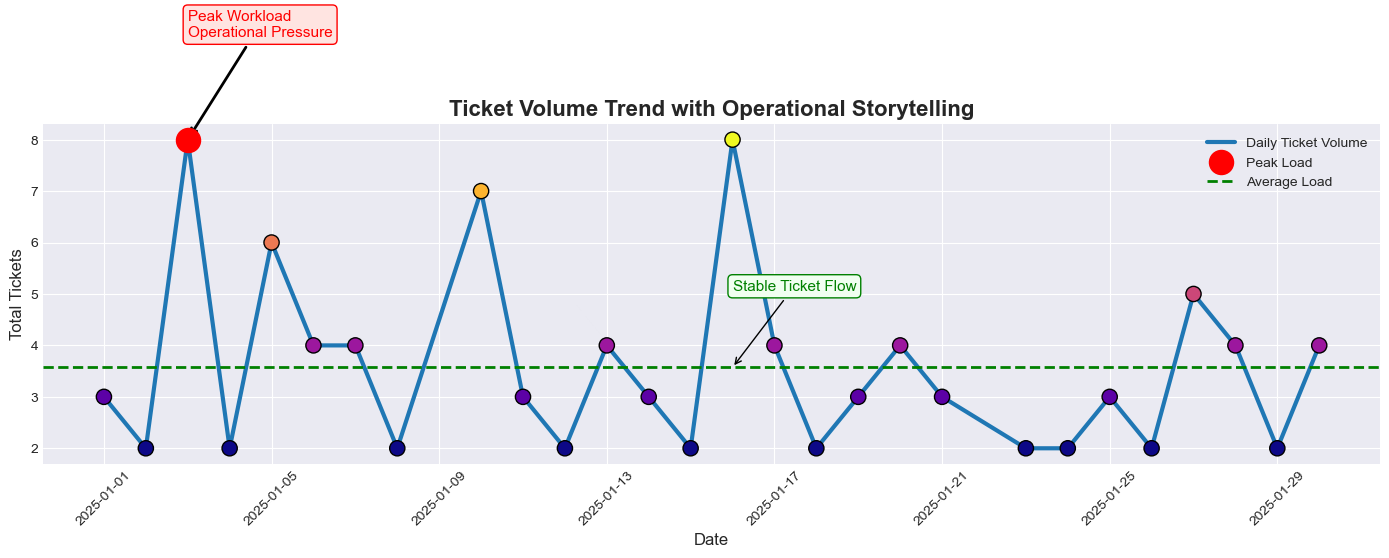

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare trend data
trend = df.groupby(df["CreatedDate"].dt.date)["TicketID"].count()

# Identify peak day
peak_day = trend.idxmax()
peak_value = trend.max()

# Create figure
plt.figure(figsize=(14,6))

# Main trend line (BLUE)
plt.plot(
    trend.index,
    trend.values,
    color="#1f77b4",
    linewidth=3,
    label="Daily Ticket Volume"
)

# Scatter points (MULTICOLOR GRADIENT)
plt.scatter(
    trend.index,
    trend.values,
    c=trend.values,
    cmap="plasma",
    s=120,
    edgecolors="black",
    zorder=3
)

# Highlight peak point (RED)
plt.scatter(
    peak_day,
    peak_value,
    color="red",
    s=300,
    zorder=5,
    label="Peak Load"
)

# Horizontal average line (GREEN)
avg_val = trend.mean()
plt.axhline(
    avg_val,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Average Load"
)

# Annotation for peak (ARROW + TEXT)
plt.annotate(
    "Peak Workload\nOperational Pressure",
    xy=(peak_day, peak_value),
    xytext=(peak_day, peak_value + 2),
    arrowprops=dict(facecolor="red", arrowstyle="->", linewidth=2),
    fontsize=11,
    color="red",
    bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose", ec="red")
)

# Annotation for stability zone
plt.annotate(
    "Stable Ticket Flow",
    xy=(trend.index[len(trend)//2], avg_val),
    xytext=(trend.index[len(trend)//2], avg_val + 1.5),
    arrowprops=dict(facecolor="green", arrowstyle="->"),
    fontsize=11,
    color="green",
    bbox=dict(boxstyle="round,pad=0.3", fc="honeydew", ec="green")
)

# Titles and labels
plt.title(
    "Ticket Volume Trend with Operational Storytelling",
    fontsize=16,
    fontweight="bold"
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Tickets", fontsize=12)

# Legend
plt.legend()

# Rotate dates
plt.xticks(rotation=45)

# Layout
plt.tight_layout()
plt.show()


/var/folders/md/2nrzbd411dq9zq60tz3q1p5r0000gn/T/ipykernel_99709/621367925.py:63: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/md/2nrzbd411dq9zq60tz3q1p5r0000gn/T/ipykernel_99709/621367925.py:63: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/md/2nrzbd411dq9zq60tz3q1p5r0000gn/T/ipykernel_99709/621367925.py:63: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/md/2nrzbd411dq9zq60tz3q1p5r0000gn/T/ipykernel_99709/621367925.py:63: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9

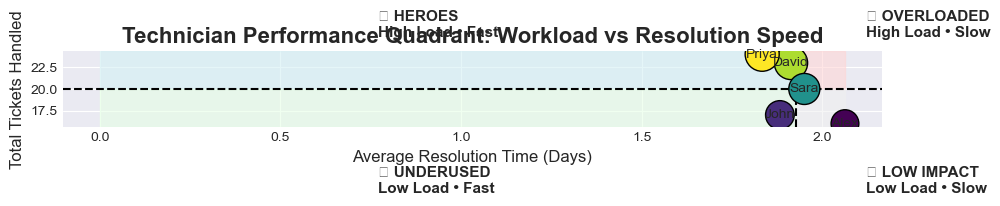

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate technician performance
tech_perf = df.groupby("Technician").agg(
    TotalTickets=("TicketID", "count"),
    AvgResolutionDays=("ResolutionDays", "mean")
)

# Calculate quadrant split points
x_mid = tech_perf["AvgResolutionDays"].mean()
y_mid = tech_perf["TotalTickets"].mean()

plt.figure(figsize=(10,7))

# --- COLORED QUADRANT BACKGROUNDS ---
plt.axvspan(0, x_mid, ymin=0.5, ymax=1, color="#d4f1f4", alpha=0.6)   # Heroes
plt.axvspan(x_mid, tech_perf["AvgResolutionDays"].max(), ymin=0.5, ymax=1, color="#ffd6d6", alpha=0.6)  # Overloaded
plt.axvspan(0, x_mid, ymin=0, ymax=0.5, color="#e6ffe6", alpha=0.6)   # Underused
plt.axvspan(x_mid, tech_perf["AvgResolutionDays"].max(), ymin=0, ymax=0.5, color="#f0f0f0", alpha=0.6) # Low impact

# --- SCATTER POINTS ---
plt.scatter(
    tech_perf["AvgResolutionDays"],
    tech_perf["TotalTickets"],
    s=tech_perf["TotalTickets"]*25,
    c=tech_perf["TotalTickets"],
    cmap="viridis",
    edgecolors="black",
    zorder=3
)

# Label each technician
for tech in tech_perf.index:
    plt.text(
        tech_perf.loc[tech, "AvgResolutionDays"],
        tech_perf.loc[tech, "TotalTickets"],
        tech,
        fontsize=10,
        ha="center",
        va="center"
    )

# --- QUADRANT LINES ---
plt.axvline(x_mid, color="black", linestyle="--")
plt.axhline(y_mid, color="black", linestyle="--")

# --- ANNOTATIONS ---
plt.text(x_mid*0.4, y_mid*1.3, "⭐ HEROES\nHigh Load • Fast", fontsize=11, weight="bold")
plt.text(x_mid*1.1, y_mid*1.3, "⚠ OVERLOADED\nHigh Load • Slow", fontsize=11, weight="bold")
plt.text(x_mid*0.4, y_mid*0.4, "🟢 UNDERUSED\nLow Load • Fast", fontsize=11, weight="bold")
plt.text(x_mid*1.1, y_mid*0.4, "❌ LOW IMPACT\nLow Load • Slow", fontsize=11, weight="bold")

# Titles & labels
plt.title(
    "Technician Performance Quadrant: Workload vs Resolution Speed",
    fontsize=16,
    fontweight="bold"
)
plt.xlabel("Average Resolution Time (Days)", fontsize=12)
plt.ylabel("Total Tickets Handled", fontsize=12)

plt.tight_layout()
plt.show()
